### CONVOLUTIONAL NETWORKS: TRAFFIC SIGNALS IN SAGEMAKER

#### Learning Objectives:

1. Basics of convolutional neural networks
2. Deep Learning
3. Image Classification
4. How to apply and deploy deep learning models at scale, in SageMaker

#### What is an Image Classifier?

Image Classifier work by predicting the class of items that are in a give image. For example, we can train a classifier to identify images of fruits, bananas, mangos, apples, etc. When we feed a trained classifier on the image of a mango for example, it will give the label to the image: "label = mango".

Let's take a look from the Fashion MNIST Dataset:

"Context

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

The original MNIST dataset contains a lot of handwritten digits. Members of the AI/ML/Data Science community love this dataset and use it as a benchmark to validate their algorithms. In fact, MNIST is often the first dataset researchers try. "If it doesn't work on MNIST, it won't work at all", they said. "Well, if it does work on MNIST, it may still fail on others.""

#### TWO CLASSIFIERS: 

1. Binary: Between two categories
2. Multi Class Classifier: There are more than two classes! We have 10 classes for example, mango, apple, banana, and so on.

When we build these deep learning based classifiers, we take all the data and images for 80-85% for training and the rest for testing.

#### We will use the Multi Class Classifier Technique

### CASE STUDY: CLASSIFYING TRAFFIC SIGNS

We will build a multi class classifier based on deep learning and neural network, convolutional networks and we will use this classfier to:

1. Classify different images.

#### USE CASES:

1. Self-driving cars: To make sure automated systems are able to classify safely between traffic signs for the purpose of security, safety, and following the law.

2. Making sure life is more important that AI systems

3. Making sure that the automated system is following the correct dorrection.

#### In this case, we have 43 different classes and this is used from the data source:

DataSource Link: Given in the notebook (German Traffic Data Set)

#### GOALS OF THE PROJECT:

1. Create a deep network called LeNet to teach and train this network to classify these images.

2. We will teach the classifier to train on red green and blue images

3. We want to be able to feed the endpoints an image, and get to know what that image means.



### CONVOLUTIONAL NEURAL NETWORKS - HOW DO THESE LEARN?

#### Basics:

1. Based on the basic AI neural networks

2. AI neural networks: Information processing models, that mimick the human intelligence

3. There is a nucleus, and collects information from dendrites and so on, and we take the information into the nucleus, we process the information through the axon.

4. We mimic this process mathematically, take all the inputs, mutliply the weights, and add a bias signal and generate an output - we apply an activation function 'f' to get an output 'A'

5. We collect many of these neurons (inputs) and we connect these to all neurons in the subsequent layer (dense/fully connected AI network)

#### Let's take a look at convulutional neural networks:

1. Let's assume we have a bunch of fruits and their classes

2. We obtain a dense fully connected AI network, but to deal with images, we add in additional steps:

    1. We take the image, apply the convulutional image
    2. We take each image, and extract the features from each of the image
    3. Pooling - we compress these feature maps, and represent the information in a reduce manner.
    4. Once we have the pool, we take the filters, flatten it, and then feed it to the dense AI network.
    


## DATA COLLECTION/VISUALIZATION

In [2]:
## Importing pickle to convert python objects into byte level streams
import pickle

## Represents opening the data: train, valid and test data
with open("test.p", mode='rb') as testing_data:
    test = pickle.load(testing_data)

    
## Mode is read binary
with open("train.p", mode='rb') as training_data:
    train = pickle.load(training_data)

with open("valid.p", mode='rb') as validation_data:
    valid = pickle.load(validation_data)

In [3]:
## Represents obtaining the features and labels within the train, test and valid

## Using a supervised deep learning technique

## We will use the validation dataset to perform cross validation
X_train, y_train = train['features'], train['labels']
X_validation, y_validation = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [4]:
X_test.shape

(12630, 32, 32, 3)

We have 12,630 images with 32 by 32 by 3 pixels

In [5]:
X_train.shape

(34799, 32, 32, 3)

In [6]:
X_validation.shape

(4410, 32, 32, 3)

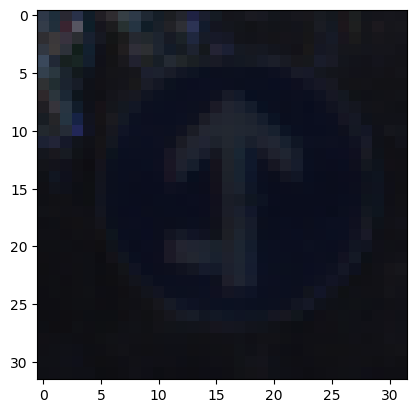

In [7]:
## Represents visualizing one sample image
import numpy as np
import matplotlib.pyplot as plt

## Going to select a random image
i = np.random.randint(1, len(X_test))

## Show the actual image
plt.imshow(X_test[i])
plt.show()

In [8]:
print('label = ', y_test[i])

label =  35


#### SHOWING THE RANDOM SORTED TRAFFIC SIGNS WITH THEIR CORRESPODING LABELS

In [9]:
l_grid = 5
w_grid = 5

In [10]:
fig, axes = plt.subplots(l_grid, w_grid, figsize = (10, 10))

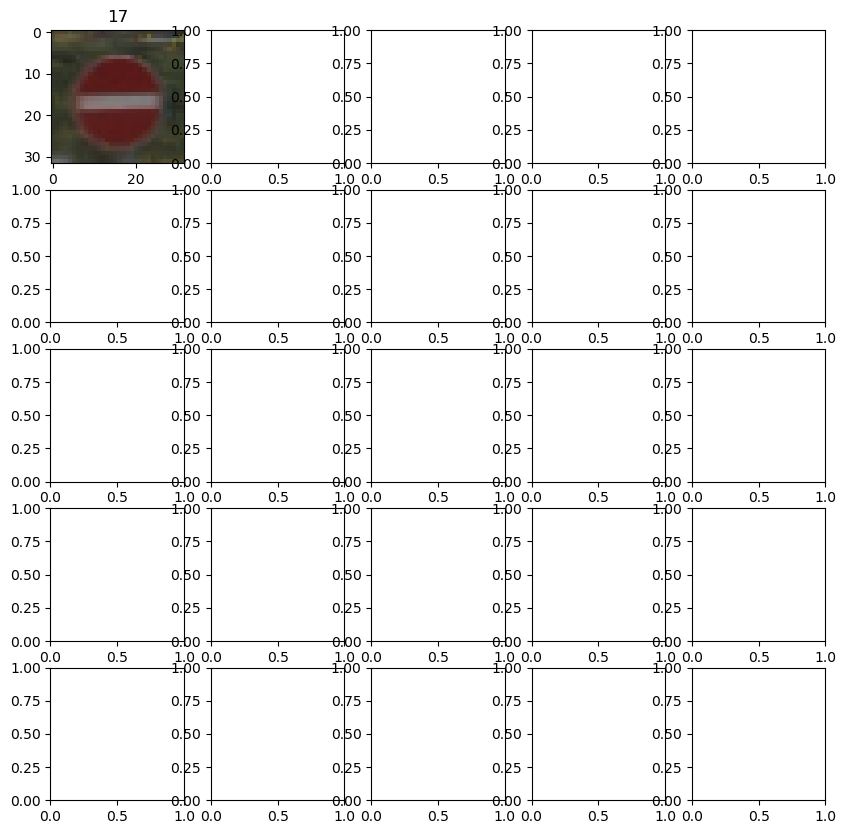

In [11]:
axes = axes.ravel()
n_training = len(X_test)
for i in np.arange(0, l_grid * w_grid):
    index = np.random.randint(0, len(X_test))
    axes[i].imshow(X_test[index])
    axes[i].set_title(y_test[index])
    plt.show()

### SAGEMAKER INTEGRATION

In [12]:
import sagemaker
import boto3

## Represents creating a sagemaker session
sagemaker_session = sagemaker.Session()

prefix = 'traffic-sign-classifier'

role = sagemaker.get_execution_role()

print(role)

arn:aws:iam::442851008302:role/service-role/AmazonSageMaker-ExecutionRole-20230713T114638


In [13]:
## Represents uploading the data into the bucket
import os
os.makedirs("./data", exist_ok = True)

In [14]:
## Represents saving the training and validation data in the data files

np.savez('./data/training', image = X_train, label = y_train)
np.savez('./data/validation', image = X_validation, label = y_validation)

In [15]:
## Now, uploading the data that we have into amazon S3

training_path = sagemaker_session.upload_data('data/training.npz', key_prefix = prefix + '/training')
valid_path = sagemaker_session.upload_data('data/validation.npz', key_prefix = prefix + '/validation')

print(training_path)
print(valid_path)

s3://sagemaker-us-east-1-442851008302/traffic-sign-classifier/training/training.npz
s3://sagemaker-us-east-1-442851008302/traffic-sign-classifier/validation/validation.npz


#### TRAINING THE CNN MODEL USING: SAGEMAKER

We will be training the LNET Model using sagemaker:

1. Step 1: Convolutional Layer 
    1. Input: 32x32x3
    2. Output: 28x28x6
    3. We will use the 5x5 filters
    We will apply the RELU activation function to give the output
    and pool layer to reduce the filters and give the output


2. Step 2: 2nd Convolutional Layer
    1. Input: 14x14x6
    2. Output: 10x10x6
    We will again, apply the RELU activation function to get the output


3. Step 3: Flattening the Network
    1. Here, we will flatten the output


4. Step 4: Fully Connected Layer
    1. We will have a fully connected layer


5. Step 5: Another Fully Connected Layer (OUTPUT LAYER --> 43 Layers)
    1. Output will be 43 at the end


--> Refer to the train-cnn.py to get the code for training the CNN model

In [16]:
## Now, we will run the trainCNN.py file to train the CNN network
!pygmentize trainCNN.py

## Represents the training code and define the network, model architecture and training
import argparse, os
import tensorflow
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras,utils import multi_gpu_model


## Training code will be run here
if __name__ == '__main__':
    
    ## Getting all of the arguments
    parser = argparse.ArgumentParser()
    
    ## Model paramters are sent as Command Line arguments
    parser.add_argument('--epochs', type=int, default = 1)
    parser.add_argument('--learning-rate', type=float, default = 0.001)
    parser.add_argument('--batch-size', type=int, default = 32)
    
    
    ## Some more important arguments to keep in mind
    
    ## How many gpus are available for training
    parser.add_argume

In [17]:
from sagemaker.tensorflow import TensorFlow

## To train the tensorflow model, we will use the estimator from the SM SDK

tf_estimator = TensorFlow(entry_point='trainCNN.py',
                         role=role, 
                         train_instance_count = 1,
                         train_instance_type = 'ml.c4.2xlarge',
                         framework_version = '1.12',
                         py_version = 'py3',
                         script_mode = True,
                         hyperparameters = {'epochs': 13, 
                                           'batch-size': 32, 
                                           'learning-rate': 0.001}
                         )

train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [20]:
tf_estimator.fit({'training': training_path, 'validation': valid_path})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: sagemaker-tensorflow-scriptmode-2023-07-21-14-06-28-405


Using provided s3_resource
2023-07-21 14:06:28 Starting - Starting the training job...
2023-07-21 14:06:45 Starting - Preparing the instances for training.........
2023-07-21 14:08:28 Downloading - Downloading input data
2023-07-21 14:08:28 Training - Training image download completed. Training in progress...2023-07-21 14:08:33,894 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2023-07-21 14:08:33,900 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2023-07-21 14:08:34,095 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2023-07-21 14:08:34,111 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2023-07-21 14:08:34,122 sagemaker-containers INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "training": "/opt/ml/input/data/training",
        "validation": "/opt/ml/input/data/validation"
    },


UnexpectedStatusException: Error for Training job sagemaker-tensorflow-scriptmode-2023-07-21-14-06-28-405: Failed. Reason: AlgorithmError: ExecuteUserScriptError:
Command "/usr/bin/python trainCNN.py --batch-size 32 --epochs 13 --learning-rate 0.001 --model_dir s3://sagemaker-us-east-1-442851008302/sagemaker-tensorflow-scriptmode-2023-07-21-14-06-28-405/model", exit code: 1

## DEPLOYING THE TRAINED MODEL

In [21]:
import time

tf_endpoint_name = 'trafficsign-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

tf_predictor = tf_estimator.deploy(initial_instance_count = 1,
                                   instance_type = 'ml.t2.medium',
                                   endpoint_name = tf_endpoint_name)

INFO:sagemaker.tensorflow.model:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating model with name: sagemaker-tensorflow-scriptmode-2023-07-21-14-13-23-593


ClientError: An error occurred (ValidationException) when calling the CreateModel operation: Could not find model data at s3://sagemaker-us-east-1-442851008302/sagemaker-tensorflow-scriptmode-2023-07-21-14-06-28-405/output/model.tar.gz.